In [65]:
%display latex

In [66]:
import numpy as np
from itertools import product, permutations

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

plt.rc('text', usetex=True)
plt.rc('font', family='sans serif')

In [67]:
N = 3
F = GF(2^3, 'x')
x = F.gen()

In [68]:
basis = [x^3, x^5, x^6]

def toInt(k):
    return list(F).index(k)

def components(k):
    return vector([(k * b).trace() for b in basis])

chi = lambda k: exp(pi * I * int(k.trace()))

y = var('y')

# compute the coefficients for the basis elements,
def solve_basis(basis, curve):
    sols = []
    for k in basis:
        sol = solve(chi(k * curve(k)) == y^2, y, solution_dict=True)
        sols.append(sol[1]) # positive solutions only (choice)
    return sols

# after computing the solutions we can simply
# get them for each basis element.
def basis_c(a, l, sols):
    if a == 0:
        return 1
    return sols[l][y]

# Compute an arbitrary coefficient c_{\alpha,f} for a 
# given curve f using the general formula.
def c(alpha, curve, sols=None):
    if not sols:
        sols = solve_basis(basis, curve)
    
    # Expand alpha in the basis
    comps = components(alpha)

    # Apply the formula
    s1 = 0
    for k in range(N-1):
        s2 = 0
        for j in range(k+1, N):
            s2 += comps[j] * basis[j]
        s1 += s2 * curve(comps[k] * basis[k])
        
    return chi(s1) * prod([basis_c(a, l, sols) for l, a in enumerate(comps)])

def sign_perm(sols, perm=None):
    if perm:
        for k, sol in enumerate(sols):
            sols[k][y] = perm[k] * sols[k][y]
    return sols

def ray(mu):
    return lambda t: mu * t

def PS(curve, perms):
    phase_space = zero_matrix(SR, 2^N, 2^N)
    phase_space[0,:] = 1 # vertical line forced by phi(0,b) = 1
    for j, mu in enumerate(F): # iterate through the curve parametr
        # same sign choice for a fixed curve parameter
        sols = sign_perm(solve_basis(basis, curve(mu)), perms[j])
        for i, a in enumerate(F):
            # loop through alpha to obtain coefficient and
            # corresponding point
            coeff = c(a, curve(mu), sols)
            b = curve(mu)(a)
            phase_space[i, toInt(b)] = coeff
    return phase_space

In [69]:
# change DPS to string type
def DPS_to_str(dps):
    psn = np.array(dps).astype('object')
    
    psn[psn == 1] = '1'
    psn[psn == -1] = '-1'
    psn[psn == 1j] = 'i'
    psn[psn == -1j] = '-i'
    
    return psn

In [70]:
def Partition(curves):
    prt = zero_matrix(SR, 8, 8)
    prt[0,:] = 8
    for mu in F:
        for a in F:
            b = curves(mu)(a)
            prt[toInt(a), toInt(b)] = toInt(mu)
    prt[0,0] = 0
    return prt

In [71]:
ps = PS(ray, [[1,1,1]] * 8)
ps

[ 1  1  1  1  1  1  1  1]
[ 1 -1 -I  1 -I  I  I -1]
[ 1 -I -1  I -I  I  1 -1]
[ 1  1  I  I  I  1  1  I]
[ 1 -I -I  I -1  1  I -1]
[ 1  I  I  1  1  I  1  I]
[ 1  I  1  1  I  1  I  I]
[ 1 -1 -1  I -1  I  I -I]

In [72]:
# palettes = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
#             'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 
#             'tab20c', 'viridis', 'gnuplot']
def DPS_heat(curve, dps, pal='gnuplot', pal_rng=(0,1), txt_col='b'):
    data   = np.rot90(np.array(Partition(curve), dtype='float64'), 0).T
    labels = np.rot90(np.array(DPS_to_str(dps)), 0).T

    pal_func = getattr(plt.cm, pal)
    col_map = colors.ListedColormap(pal_func(np.linspace(*pal_rng, 2^N+1)))
    
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=col_map,
                   vmin=np.min(data) - 0.5, 
                   vmax=np.max(data) + 0.5,
                   origin='lower')
    
    F_lab = [r'$0$', r'$\sigma$'] + [rf'$\sigma^{k}$' for k in range(2,8)]
    ax.set_xticks(range(8))
    ax.set_xticklabels(F_lab)
    ax.set_yticks(range(8))
    ax.set_yticklabels(F_lab)

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$', rotation='horizontal', labelpad=10)
    
    # Display the custom labels within each entry
    for i in range(len(labels)):
        for j in range(len(labels[0])):
            text = ax.text(j, i, f'${labels[i][j]}$',
                           ha="center", va="center", color=txt_col)
    
    cbar = ax.figure.colorbar(im, ax=ax,
                              ticks=np.arange(np.min(data), np.max(data) + 1),
                              fraction=0.05, pad=0.04)
    cbar.ax.set_yticklabels(F_lab + [r'$\infty$'])
    cbar.ax.set_xlabel(r'$\mu$', labelpad=5)
    
    return fig, ax

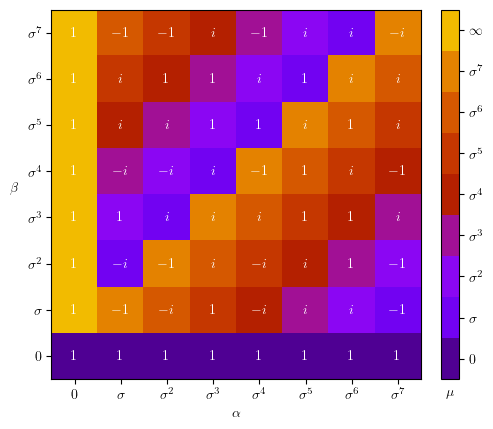

In [73]:
fig, ax = DPS_heat(ray, ps, pal='gnuplot', pal_rng=(.1,.9), txt_col='w')

In [74]:
bbox = fig.bbox_inches.from_bounds(1, 0, 5.2, 4.5)
fig.savefig('./paper_graphs/DPS_rays_heat.eps', format='eps', bbox_inches=bbox)

In [75]:
def DPS_line(curve, dps, pal='gnuplot'):
    fig, ax = plt.subplots()
    
    F_lab = [r'$0$', r'$\sigma$'] + [rf'$\sigma^{k}$' for k in range(2,2^N)]
    F_lab_ext = [r'$\infty$'] + F_lab
    ax.set_xticks(range(2^N))
    ax.set_xticklabels(F_lab)
    ax.set_yticks(range(2^N))
    ax.set_yticklabels(F_lab)

    dps_str = DPS_to_str(dps)
    for i in range(8):
        for j in range(8):
            t = ax.text(i, j, f'${dps_str[i,j]}$',
                        fontsize=12, ha='center', va='center',
                        color='white')
            # t.set_bbox(dict(facecolor='white', linewidth=0, alpha=0.3))

    pal_func = getattr(plt.cm, pal)
    line_colors = pal_func(np.linspace(0,0.9,2^N+1))

    # Get curves
    points = [[(0, toInt(k)) for k in F]]
    for mu in F:
        points.append([(toInt(k), toInt(curve(mu)(k))) for k in F])
    
    for i, pts in enumerate(points):
        ax.plot(*zip(*pts),
                alpha=0.5, zorder=-1,
                label=F_lab_ext[i],
                color=line_colors[i]
               )
        ax.scatter(*zip(*pts), marker='o', s=500,
                   zorder=0, linewidths=2, edgecolors='white',
                   color=line_colors[i],
                  )
    
    plt.legend(loc=(1.02, 0.515))
    
    return fig, ax

(<Figure size 640x480 with 1 Axes>, <Axes: >)

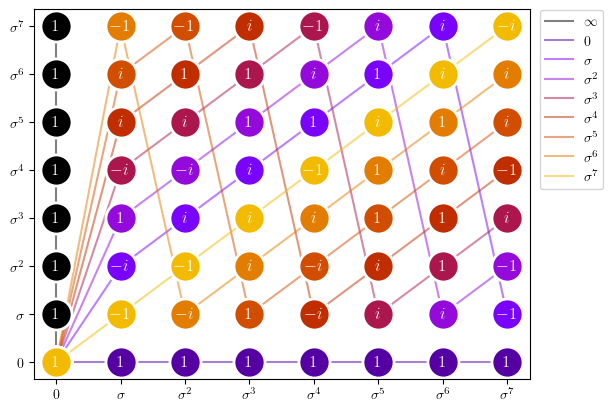

In [76]:
DPS_line(ray, ps, 'gnuplot')

In [77]:
# bbox = fig.bbox_inches.from_bounds(0.2, 0, 6.5, 4.5)
# fig.savefig('./paper_graphs/DPS_rays.eps', format='eps', bbox_inches=bbox)

---

Let's now calculate the DPS for the curve given by Sainz $\beta = \phi_0 \alpha + \alpha + \alpha^2$. This curve is not appropriate. The general form is given by
$$
\beta = \phi_0 \alpha + \phi^2 \alpha^2 + \phi \alpha^4.
$$

In [78]:
def sainz_curve(phi0):
    # return lambda k: phi0 * k + x^2 * k^2 + x * k^4 # phi = \sigma
    return lambda k: phi0 * k + k^2 + k^4 # phi = 1

In [79]:
Partition(sainz_curve)

[0 8 8 8 8 8 8 8]
[7 0 3 6 1 5 4 2]
[7 2 0 3 6 1 5 4]
[5 0 1 4 6 3 2 7]
[7 5 4 2 0 3 6 1]
[6 4 3 1 0 2 5 7]
[3 5 0 6 2 4 1 7]
[0 1 2 3 4 5 6 7]

In [80]:
ps = PS(sainz_curve, [[1,1,1]] * 8)
ps

[ 1  1  1  1  1  1  1  1]
[ 1 -1  I  1  I -I -I -1]
[ 1  I -1 -I  I -I  1 -1]
[ 1  1  I  I  I  1  1  I]
[ 1  I  I -I -1  1 -I -1]
[ 1  I  I  1  1  I  1  I]
[ 1  I  1  1  I  1  I  I]
[-1  1  1 -I  1 -I -I  I]

In [81]:
for mu in F:
    # curve = sainz_curve(mu)
    curve = ray(mu)
    sols = sign_perm(solve_basis(basis, curve), [1,1,1])
    for k in F:
        for kp in F:
            lhs = c(k, curve, sols) * c(kp, curve, sols)
            rhs = chi(kp * curve(k)) * c(k + kp, curve, sols)
            if lhs != rhs:
                raise Exception('Recurrence relation does not hold!', mu)
print('Recurrence relation holds!')

Recurrence relation holds!


In [82]:
# verify recurrence relation
for phi0 in F:
    for t1 in F:
        for t2 in F:
            a1, b1 = (t1, sainz_curve(phi0)(t1))
            a2, b2 = (t2, sainz_curve(phi0)(t2))
            a3, b3 = (t1 + t2, sainz_curve(phi0)(t1 + t2))
            phase1 = ps[toInt(a1), toInt(b1)]
            phase2 = ps[toInt(a2), toInt(b2)]
            phase3 = ps[toInt(a3), toInt(b3)]
            if phase1 * phase2 != phase3 * chi(a2 * b1):
                print(phi0, t1, t2)
                print(phase1 * phase2, phase3 * chi(a2 * b1))
                raise Exception
print('Recurrence relation holds!')

Recurrence relation holds!


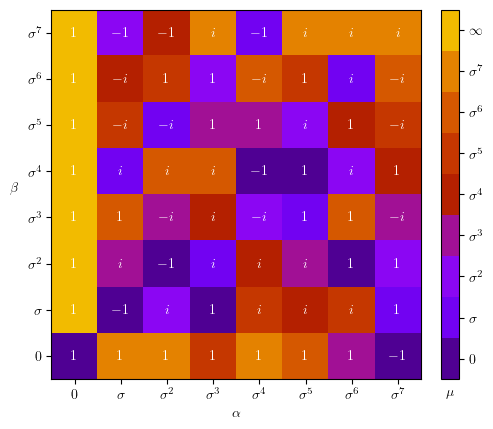

In [83]:
fig, ax = DPS_heat(sainz_curve, ps, pal='gnuplot', pal_rng=(.1,.9), txt_col='w')

In [86]:
bbox = fig.bbox_inches.from_bounds(1, 0, 5.2, 4.5)
fig.savefig('./paper_graphs/DPS_curve_heat_correct.eps', format='eps', bbox_inches=bbox)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

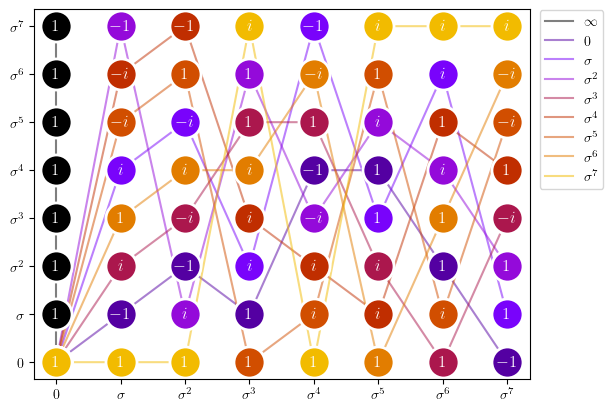

In [87]:
DPS_line(sainz_curve, ps, 'gnuplot')

---
MUBS for Sainz.

Construct the rotation operators to create MUBs.

In [88]:
ps = PS(ray, [[1,1,1]] * 8)

In [138]:
def Proj(u, v=None):
    if not v:
        v = u
    return u.tensor_product(v.conjugate_transpose())

Id = identity_matrix(2^N)

def Fourier():
    s = zero_matrix(SR, 2^N, 2^N)
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            s[i,j] = chi(a * b) / sqrt(2^N)
    return s
FF = Fourier()

def phi(a, b, dps=ps):
    return dps[toInt(a), toInt(b)]

def Z(a):
    return diagonal_matrix([chi(a * k) for k in F])

def X(b):
    return FF.conjugate_transpose() * Z(b) * FF

def D(a, b):
    return phi(a, b) * Z(a) * X(b)

def V(xi, curve=None):
    if not curve:
        curve = lambda t: xi * t
    sols = solve_basis(basis, curve)
    
    s = zero_matrix(SR, 2**N, 2**N)
    for i, k in enumerate(F):
        s += c(k, curve, sols) * Proj(FF[:,i])
    return s

In [139]:
mubs306 = [FF] + [V(mu) for mu in F]

In [140]:
mubs306[8] * 4

[ I - 1 -I + 1 -I + 1  I + 1 -I + 1  I + 1  I + 1 -I - 1]
[-I + 1  I - 1 -I + 1 -I - 1 -I + 1  I + 1  I + 1  I + 1]
[-I + 1 -I + 1  I - 1  I + 1 -I + 1  I + 1 -I - 1  I + 1]
[ I + 1 -I - 1  I + 1  I - 1  I + 1 -I + 1 -I + 1 -I + 1]
[-I + 1 -I + 1 -I + 1  I + 1  I - 1 -I - 1  I + 1  I + 1]
[ I + 1  I + 1  I + 1 -I + 1 -I - 1  I - 1 -I + 1 -I + 1]
[ I + 1  I + 1 -I - 1 -I + 1  I + 1 -I + 1  I - 1 -I + 1]
[-I - 1  I + 1  I + 1 -I + 1  I + 1 -I + 1 -I + 1  I - 1]

In [92]:
# same thing so far
s_test = zero_matrix(SR, 2**N, 2**N)
for i, k in enumerate(F):
    s_test += phi(k, ray(F(1))(k)) * Proj(FF[:,i])
s_test * 4

[ I - 1 -I + 1 -I + 1  I + 1 -I + 1  I + 1  I + 1 -I - 1]
[-I + 1  I - 1 -I + 1 -I - 1 -I + 1  I + 1  I + 1  I + 1]
[-I + 1 -I + 1  I - 1  I + 1 -I + 1  I + 1 -I - 1  I + 1]
[ I + 1 -I - 1  I + 1  I - 1  I + 1 -I + 1 -I + 1 -I + 1]
[-I + 1 -I + 1 -I + 1  I + 1  I - 1 -I - 1  I + 1  I + 1]
[ I + 1  I + 1  I + 1 -I + 1 -I - 1  I - 1 -I + 1 -I + 1]
[ I + 1  I + 1 -I - 1 -I + 1  I + 1 -I + 1  I - 1 -I + 1]
[-I - 1  I + 1  I + 1 -I + 1  I + 1 -I + 1 -I + 1  I - 1]

Before doing state tomography. Let's verify that the distinct formulas used to create the eigenstates are really equal when using the same hyperparameters (sign permutations). In particular we need to verify that for the case of the all positive solution and the rays $f(\alpha) = \lambda \alpha$, the following equality holds:
$$
\ket{\psi_\kappa^\lambda} \bra{\psi_\kappa^\lambda}
= \sum_{\tau} \chi(\tau \kappa) D(\tau, \lambda \tau)
= V_\lambda \ket{\kappa} \bra{\kappa} V_\lambda^*
$$
where $V_\lambda$ is the rotation operator corresponding to the curve parametrized by $\lambda$:
$$
V_\lambda = \sum_{\kappa} c(\lambda, \kappa) \ket{\tilde\kappa} \bra{\tilde\kappa}.
$$

In [93]:
# kappa = 0
for k in F:
    for l in F:
        s_lk = zero_matrix(SR, 2^N, 2^N)
        for t in F:
            s_lk += chi(t * k) * D(t, ray(l)(t))
        if s_lk != Proj(V(l)[:,toInt(k)]) * 2^N:
            raise Exception

Good, so the projections of MUBs, $\ket{\psi_\kappa^\lambda}\bra{\psi_\kappa^\lambda}$ generated by both manners, i.e., as a sum of displacement operators along the curve and as a rotation operator, is equal.

One final check, Klimov wants to verify that the MUBs that I obtain using the rotation operators can be (explicitly) expressed in the following manner:
$$
\ket{\psi_\kappa^\lambda}
= \frac{1}{\sqrt{p^n}} \sum_{\alpha,\gamma \in \mathbb F} \Phi(\alpha,\lambda\alpha) (-1)^{\alpha(\kappa+\gamma)} \ket{\gamma},
$$
and
$$
\ket{\tilde\psi_\kappa}
= \frac{1}{\sqrt{p^n}} \sum_{\alpha,\gamma \in \mathbb F} (-1)^{tr(\kappa\gamma)} \ket{\gamma}.
$$

In [94]:
# generate MUBs using the expression above
FB = zero_matrix(SR, 2^N, 2^N)
for k in F:
    for g in F:
        FB[toInt(g), toInt(k)] = (-1)^int((k * g).trace()) / sqrt(2^N)

In [95]:
FF == FB

True

In [96]:
for l in F:
    Bl = zero_matrix(SR, 2^N, 2^N)
    for k in F:
        for a in F:
            for g in F:
                Bl[toInt(g), toInt(k)] += phi(a, ray(l)(a)) * (-1)^int((a * (k + g)).trace()) / 2^N
    if Bl != V(l):
        raise Exception

---

Quantum state tomography. Simply calculate the probabilities:
$$
p_\kappa^{(\lambda)} = \bra{\psi_\kappa^\lambda} \hat\rho \ket{\psi_\kappa^\lambda},
$$
in order to express the state $\hat\rho$ as a decomposition of the projection operators $\ket{\psi_\kappa^\lambda}\bra{\psi_\kappa^\lambda}$:
$$
\hat\rho = \sum_{\kappa,\lambda} p_\kappa^{(\lambda)} \ket{\psi_\kappa^\lambda}\bra{\psi_\kappa^\lambda} - \hat I.
$$

In [97]:
# GHZ state
rho = Proj((Id[:,0] + Id[:,-1]) / sqrt(2))
Matrix(rho)

[1/2   0   0   0   0   0   0 1/2]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[  0   0   0   0   0   0   0   0]
[-------------------------------]
[1/2   0   0   0   0   0   0 1/2]

In [98]:
def StateRec(rho, mubs):
    rho_reconst = zero_matrix(SR, 2^N, 2^N)
    for i in range(2^N+1):
        for j in range(2^N):
            v = mubs[i][:,j]
            pkl = v.conjugate_transpose() * rho * v
            # rho_reconst += pkl[0,0] * Proj(v)
            rho_reconst += (pkl[0,0] - 1/(2^N+1)) * Proj(v)
    # rho_reconst -= Id
    return rho_reconst

In [99]:
StateRec(rho, mubs306)

[1/2   0   0   0   0   0   0 1/2]
[  0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0]
[1/2   0   0   0   0   0   0 1/2]

In [100]:
def ProbMatrix(rho, mubs):
    probs = zero_matrix(SR, 2^N+1, 2^N)
    for i in range(2^N+1):
        for j in range(2^N):
            v = mubs[i][:,j]
            pkl = v.conjugate_transpose() * rho * v
            probs[i,j] = pkl[0,0]
    return probs

In [101]:
ProbMatrix(rho, mubs306)

[1/4 1/4 1/4   0 1/4   0   0   0]
[1/2   0   0   0   0   0   0 1/2]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[  0 1/4 1/4 1/4   0   0 1/4   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[  0 1/4   0 1/4 1/4 1/4   0   0]
[  0   0 1/4   0 1/4 1/4 1/4   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]

Now let's reconstruct the two states in the figure of the paper.

In [102]:
state1 = zero_matrix(SR, 2^N, 2^N)
state2 = zero_matrix(SR, 2^N, 2^N)

In [103]:
state1[:,0] = vector([1/4, 0, -I/4, 0, 0, 0, -I/4, -1/4])
state1[:,2] = vector([1/4, 0, -I/4, 0, 0, 0, -I/4, -1/4]) * I
state1[:,6] = vector([1/4, 0, -I/4, 0, 0, 0, -I/4, -1/4]) * I
state1[:,7] = vector([1/4, 0, -I/4, 0, 0, 0, -I/4, -1/4]) * (-1)

In [104]:
state1

[   1/4      0  1/4*I      0      0      0  1/4*I   -1/4]
[     0      0      0      0      0      0      0      0]
[-1/4*I      0    1/4      0      0      0    1/4  1/4*I]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[-1/4*I      0    1/4      0      0      0    1/4  1/4*I]
[  -1/4      0 -1/4*I      0      0      0 -1/4*I    1/4]

In [105]:
state2[:,0] = vector([1/2, -I/2, 0, 0, 0, 0, 0, 0])
state2[:,1] = vector([1/2, -I/2, 0, 0, 0, 0, 0, 0]) * I

In [106]:
state2

[   1/2  1/2*I      0      0      0      0      0      0]
[-1/2*I    1/2      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]

In [107]:
StateRec(state1, mubs306)

[   1/4      0  1/4*I      0      0      0  1/4*I   -1/4]
[     0      0      0      0      0      0      0      0]
[-1/4*I      0    1/4      0      0      0    1/4  1/4*I]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[-1/4*I      0    1/4      0      0      0    1/4  1/4*I]
[  -1/4      0 -1/4*I      0      0      0 -1/4*I    1/4]

In [108]:
StateRec(state2, mubs306)

[   1/2  1/2*I      0      0      0      0      0      0]
[-1/2*I    1/2      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0]

In [109]:
ProbMatrix(state1, mubs306)

[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/4   0 1/4   0   0   0 1/4 1/4]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/4   0   0   0 1/4 1/4   0 1/4]
[1/4   0   0 1/4 1/4   0 1/4   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/2 1/2   0   0   0   0   0   0]
[1/4   0 1/4 1/4   0 1/4   0   0]

In [110]:
ProbMatrix(state2, mubs306)

[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/2 1/2   0   0   0   0   0   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[1/4   0 1/4 1/4   0 1/4   0   0]
[1/4   0   0 1/4 1/4   0 1/4   0]
[  0 1/4 1/4 1/4   0   0 1/4   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]
[  0 1/4   0 1/4 1/4 1/4   0   0]
[1/8 1/8 1/8 1/8 1/8 1/8 1/8 1/8]

In [111]:
ProbMatrix(state1, mubs306) - 1/(2^N+1) * ones_matrix(SR, 2^N+1, 2^N)

[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[5/36 -1/9 5/36 -1/9 -1/9 -1/9 5/36 5/36]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[5/36 -1/9 -1/9 -1/9 5/36 5/36 -1/9 5/36]
[5/36 -1/9 -1/9 5/36 5/36 -1/9 5/36 -1/9]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[7/18 7/18 -1/9 -1/9 -1/9 -1/9 -1/9 -1/9]
[5/36 -1/9 5/36 5/36 -1/9 5/36 -1/9 -1/9]

In [112]:
ProbMatrix(state2, mubs306) - 1/(2^N+1) * ones_matrix(SR, 2^N+1, 2^N)

[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[7/18 7/18 -1/9 -1/9 -1/9 -1/9 -1/9 -1/9]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[5/36 -1/9 5/36 5/36 -1/9 5/36 -1/9 -1/9]
[5/36 -1/9 -1/9 5/36 5/36 -1/9 5/36 -1/9]
[-1/9 5/36 5/36 5/36 -1/9 -1/9 5/36 -1/9]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]
[-1/9 5/36 -1/9 5/36 5/36 5/36 -1/9 -1/9]
[1/72 1/72 1/72 1/72 1/72 1/72 1/72 1/72]

In [113]:
sum(sum(ProbMatrix(state2, mubs306) - 1/(2^N+1) * ones_matrix(SR, 2^N+1, 2^N)))

1

---
We now need to verify Sainz's claim in the paper. The paper states the following:

For the primitive polynomial $\sigma^3 + \sigma + 1 = 0$ and the self-dual basis $\{\sigma^3,\sigma^5,\sigma^6\}$, the regular curves $\beta = f(\alpha) = \phi_0 \alpha + \phi^2 \alpha^2 + \phi \alpha^4$ are abelian under the _positive sign election_, if the following relations hold:
1. if $\phi = \sigma,\sigma^2,\sigma^4$ then $\phi_0 = \phi,\phi^2,\phi^3,\phi^6$.
2. if $\phi = \sigma^3,\sigma^5,\sigma^6$ then $\phi_0 = 0,1$,
3. if $\phi = 1$, there are no $\phi_0$ producing abelian curves.

So what we need to verify is that for the fixed DPS of the rays these curves are indeed abelian.

In [114]:
def testCurve(points):
    for p1 in points:
        for p2 in points:
            p_op = D(*p1) * D(*p2)
            s_op = D(p1[0] + p2[0], p1[1] + p2[1])
            if p_op != s_op:
                raise Exception(p1, p2)
    return True

In [115]:
def phi_curve(fi):
    def phi0_curve(fi0):
        return lambda a: fi0 * a + fi^2 * a^2 + fi * a^4
    return phi0_curve

In [116]:
# Relation 1
for fi in [x, x^2, x^4]:
    for phi0 in [fi, fi^2, fi^3, fi^6]:
        points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
        testCurve(points)

In [117]:
# Relation 2
for fi in [x^3, x^5, x^6]:
    for phi0 in [F(0), F(1)]:
        points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
        testCurve(points)

In [118]:
# Relation 3
fi = F(1)
for phi0 in F:
    points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
    try:
        testCurve(points)
        raise Exception('Found an abelian curve!', phi0)
    except:
        continue

So the statements are verified for the chosen DPS in the paper. Now for the a changed discrete phase for the rays, i.e., with different sign choices, Sainz states that the following curves become abelian:
1. if $\phi = \sigma,\sigma^2,\sigma^4$, then $\phi_0 = \phi + \phi^2$;
2. if $\phi = \sigma^3,\sigma^5,\sigma^6$ then $\phi_0 = \phi + \phi^2$;
3. if $\phi = 1$, then $\phi_0 = 0$.

The difficulty in verifying this is _how_ she chose the sign changes. She specifically states that the sign changes which make the above possible is $\Phi_{\alpha,\mu\alpha}(\theta_k) = -\sqrt{\chi\left(\mu \theta_k^2\right)}$, although I suppose she meant $\Phi_{\theta_k,\mu\theta_k}$, for all $\mu \neq 0$. But she probably meant that she changed all the phases of DPS _directly_.

Let me test the first change.

In [137]:
ps = PS(ray, [[1,1,1]] + [[-1,-1,-1]] * 7)
ps # DON'T FORGET TO RECALCULATE PHI

[ 1  1  1  1  1  1  1  1]
[ 1 -1 -I  1 -I  I  I -1]
[ 1 -I -1  I -I  I  1 -1]
[ 1 -1 -I -I -I -1 -1 -I]
[ 1 -I -I  I -1  1  I -1]
[ 1 -I -I -1 -1 -I -1 -I]
[ 1 -I -1 -1 -I -1 -I -I]
[ 1  1  1 -I  1 -I -I  I]

In [141]:
# Relation 1
for fi in [x, x^2, x^4]:
    phi0 = fi + fi^2
    points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
    print(testCurve(points))

True
True
True


In [142]:
# Relation 2
for fi in [x^3, x^5, x^6]:
    phi0 = fi + fi^2
    points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
    print(testCurve(points))

True
True
True


In [143]:
fi = F(1)
phi0 = F(0)
points = [(a, phi_curve(fi)(phi0)(a)) for a in F]
testCurve(points)

True

In [144]:
curve50 = lambda a: x^2 * a + x^3 * a^2 + x^5 * a^4
[curve50(a) for a in F]

[0, 0, x, 0, x, x, x, 0]

In [145]:
testCurve([(a, curve50(a)) for a in F])

True